# 목차
> ## 1. 세그멘테이션과 이를 활용한 함수만들기
> ## 2. 인물사진, 강아지사진, 크로마키사진을 통해 적용해보기
> ## 3. 회고

## 필요한 라이브러리를 불러옵니다.

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 이미지의 경로를 설정하고 읽어봅니다.

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image10.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1280, 965, 3)


## 세그멘테이션

### 모델클래스를 만들기 전에 세그멘테이션에 대하여 알아보겠습니다.
* 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션이라고 합니다. <br/>이미지 세그멘테이션은 모든 픽셀에 라벨을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정합니다. <br/>이때 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. <br/>물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.

## 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들겠습니다.

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

* preprocess는 전처리고, 실제로 실행하는건 run입니다.

## 구글에서 제공하는 파일을 다운로드 하고 사전에 학습된 가중치를 불러옵니다. 

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


* 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다.

## 준비한 이미지를 네트워크에 입력합니다.

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1280, 965, 3) (513, 386, 3) 15


* img_orig 의 크기는 1280x965 이고 img_resized 의 크기는 513x386 이 출력됐습니다.

## 세그멘테이션 맵에서 가장 큰 값을 뜻하는 seg_map.max() 는 15 라는 값이 출력됩니다. 무슨 의미일까요?

* 밑에 라벨에서 보면 사람의 person이 15번 인덱스를 가집니다. 물체로 인식된 라벨 중 가장 큰 값이 사람이라서 15라고 나왔습니다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

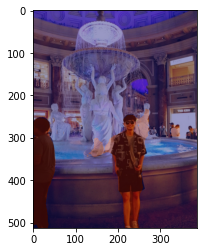

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 예측 중 사람만 추출하기 위해 15번 인덱스를 사용합니다.

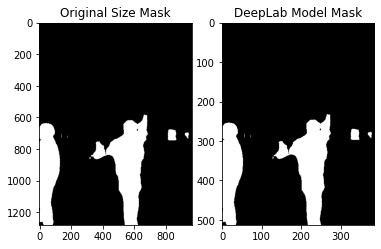

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 사람과 배경을 구분하여 출력했습니다.

* 사람이 아닌 물체도 사람으로 인식하고 멀리 떨어져 있는 사람도 인식해서 문제점이 보입니다.

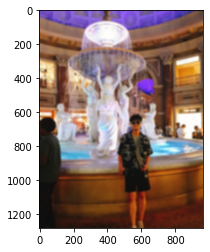

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 이미지를 흐리게 만들었습니다.

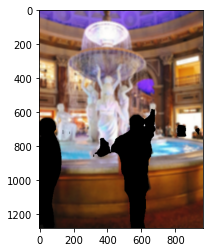

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 사람이라 인식한 부분을 제거하겠습니다.

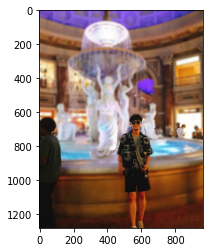

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 처음에 분리 했던 사람과 흐린 배경을 합쳤습니다.

## 강아지로 같은 과정을 반복하겠습니다.

In [21]:
img_path_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/image11.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_2 = cv2.imread(img_path_2) 
print (img_orig_2.shape)

(1280, 1003, 3)


In [36]:
img_resized_2, seg_map_2 = MODEL.run(img_orig_2)
print (img_orig_2.shape, img_resized_2.shape, seg_map_2.max())

(1280, 1003, 3) (513, 401, 3) 12


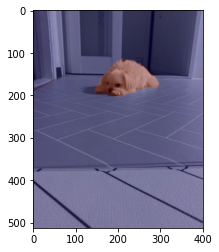

In [37]:
img_show_2 = img_resized_2.copy()
seg_map_2 = np.where(seg_map_2 == 12, 12, 0) # 예측 중 강아지만 추출
img_mask_2 = seg_map_2 * (255/seg_map_2.max()) # 255 normalization
img_mask_2 = img_mask_2.astype(np.uint8)
color_mask_2 = cv2.applyColorMap(img_mask_2, cv2.COLORMAP_JET)
img_show_2 = cv2.addWeighted(img_show_2, 0.6, color_mask_2, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_2, cv2.COLOR_BGR2RGB))
plt.show()

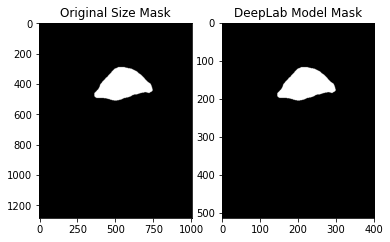

In [38]:
img_mask_up_2 = cv2.resize(img_mask_2, img_orig_2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_2 = cv2.threshold(img_mask_up_2, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_2, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_2, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

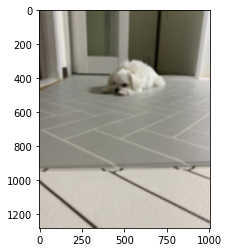

In [39]:
img_orig_blur_2 = cv2.blur(img_orig_2, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur_2, cv2.COLOR_BGR2RGB))
plt.show()

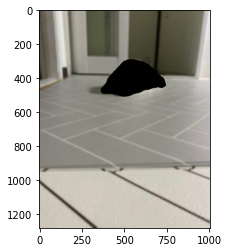

In [40]:
img_mask_color_2 = cv2.cvtColor(img_mask_up_2, cv2.COLOR_GRAY2BGR)
img_bg_mask_2 = cv2.bitwise_not(img_mask_color_2)
img_bg_blur_2 = cv2.bitwise_and(img_orig_blur_2, img_bg_mask_2)
plt.imshow(cv2.cvtColor(img_bg_blur_2, cv2.COLOR_BGR2RGB))
plt.show()

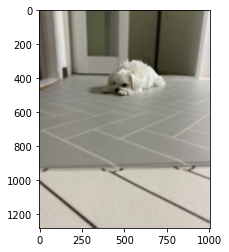

In [43]:
img_concat_2 = np.where(img_mask_color_2==255, img_orig_2, img_bg_blur_2)
plt.imshow(cv2.cvtColor(img_concat_2, cv2.COLOR_BGR2RGB))
plt.show()

## 기본 사진이 강아지만 선명하게 찍은 사진이라 처음 사진과 크게 차이가 없습니다.

## 인물사진에 배경을 합성해보겠습니다.

In [62]:
img_path_3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/image12.jpg' # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path_4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/image14.png'
img_orig_3 = cv2.imread(img_path_3)
img_orig_4 = cv2.imread(img_path_4)

In [63]:
img_resized_3, seg_map_3 = MODEL.run(img_orig_3)
print (img_orig_3.shape, img_resized_3.shape, seg_map_3.max())

(897, 1280, 3) (359, 513, 3) 15


In [64]:
img_resized_4, seg_map_4 = MODEL.run(img_orig_4)
print (img_orig_4.shape, img_resized_4.shape, seg_map_4.max())

(897, 1280, 3) (359, 513, 3) 0


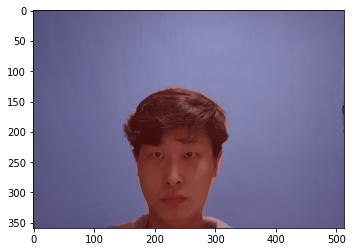

In [53]:
img_show_3 = img_resized_3.copy()
seg_map_3 = np.where(seg_map_3 == 15, 15, 0) # 예측 중 강아지만 추출
img_mask_3 = seg_map_3 * (255/seg_map_3.max()) # 255 normalization
img_mask_3 = img_mask_3.astype(np.uint8)
color_mask_3 = cv2.applyColorMap(img_mask_3, cv2.COLORMAP_JET)
img_show_3 = cv2.addWeighted(img_show_3, 0.6, color_mask_3, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_3, cv2.COLOR_BGR2RGB))
plt.show()

* 초록 배경이 없어 흰배경으로 찍었습니다.

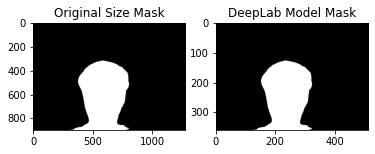

In [54]:
img_mask_up_3 = cv2.resize(img_mask_3, img_orig_3.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_3 = cv2.threshold(img_mask_up_3, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_3, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_3, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

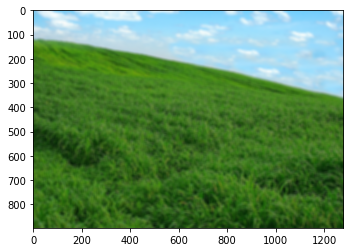

In [65]:
img_orig_blur_3 = cv2.blur(img_orig_4, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur_3, cv2.COLOR_BGR2RGB))
plt.show()

## 윈도우 배경화면 입니다.

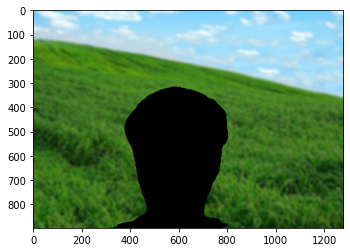

In [66]:
img_mask_color_3 = cv2.cvtColor(img_mask_up_3, cv2.COLOR_GRAY2BGR)
img_bg_mask_3 = cv2.bitwise_not(img_mask_color_3)
img_bg_blur_3 = cv2.bitwise_and(img_orig_blur_3, img_bg_mask_3)
plt.imshow(cv2.cvtColor(img_bg_blur_3, cv2.COLOR_BGR2RGB))
plt.show()

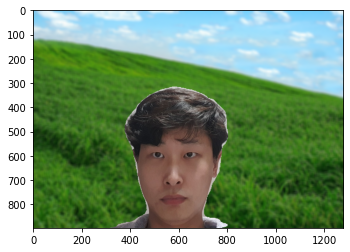

In [68]:
img_concat_3 = np.where(img_mask_color_3==255, img_orig_3, img_bg_blur_3)
plt.imshow(cv2.cvtColor(img_concat_3, cv2.COLOR_BGR2RGB))
plt.show()

* 이미지를 처리 하는 과정에서 인물과 배경의 경계 부분도 같이 작업하기 때문에 나중에 이미지를 합치는 과정에서 배경에 있는 인물 영역이 실제 사진의 인물 영역보다 넓어져 합친 후의 이미지에서 경계 주위로 어색한 것을 볼 수 있습니다.

* 3가지 사진을 살펴보면서 문제점은 각각 사진 밑에 적었습니다.

## 문제점을 개선할 수 있는 솔루션 제시

* 첫번째 사진의 문제점을 개선해 보기 위해 이런 방법을 생각해 보았습니다.

![image](https://user-images.githubusercontent.com/84653776/138885800-9c92d4a7-55be-495f-a259-0169b785ee77.png)

* 첫번째 사진의 문제점은 멀리 있는 사람과 뒤에 있는 조각상, 옆에 떨어져있는 사람 3가지 문제점이 있었습니다. 이중에 멀리 떨어져 있는 사람과 뒤에 있는 조각상은 카메라와 사람사이의 거리와 많이 차이가 나기 때문에 이동시간정보와 블러처리한 이미지를 교집합하면 처리 할 수 있을 것 같습니다.

# 회고
* 이번 익스에서 가장 어려웠던점은 솔루션 제시 였던거 같습니다. 하지만 완벽하게 수행하진 못 한것같습니다. 세그멘테이션의 원리와 deeplab의 방식의 논문을 찾아봐서 읽어 보았지만 아직 세부적으로 이해하지 못해 정확히 어떤 부분에 함수를 추가하여 문제를 해결 할지 잘 모르겠습니다.
* 두번째는 간단한 이슈 였는데 3번째 사진에서 배경과 인물을 합성할때, 합성할 사진과 인물사진의 크기가 달라 오류가 났지만, 오류 메시지를 보고 바로 수정했습니다.
* 마지막으로 세그멘테이션을 공부하는 과정에서 이를 활용한 여러가지 알고리즘을 알게 되었는데 공부하면 할수록 공부할 양이 늘어나는 인공지능의 재미를 알아가는것 같습니다.